In [1]:
#pip install ee

In [2]:
#pip install geemap

# Import Libraries

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO

#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
# DOC DATA 
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L','SITE_ID', 'DATE_SMP'])

# Read the "Site Information" Excel sheet to get the mapping between lake names and SITE_ID
site_info_df = pd.read_excel('Site_Information_2022_8_1 (2).xlsx', usecols=['SITE_ID', 'PROGRAM_ID', 'LAKE_DEPTH_MEAN', 'SITE_NAME'])


# PROF. Coordinates 
data_path = 'ALTM-50-stations.xlsx'
df_lake_info = pd.read_excel(data_path, sheet_name='updated station coordinates', usecols=['SITE_ID', 'SITE_NAME','LATDD_CENT', 'LONDD_CENT'])


merge_data = pd.merge(data_doc, site_info_df, on='SITE_ID')
merge_data = pd.merge(merge_data, df_lake_info, on= ['SITE_ID', 'SITE_NAME'])

data_modify = merge_data[merge_data['PROGRAM_ID']=='LTM_ALTM']

In [5]:
data_modify

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT
0,040850,1997-09-22,3.100000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
2,040850,1995-03-02,3.031000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
4,040850,1996-08-19,3.595000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
6,040850,2003-11-06,4.232000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
8,040850,2005-07-11,3.344000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
...,...,...,...,...,...,...,...,...
17863,1A3-048,2011-05-18,4.283944,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17864,1A3-048,2015-06-10,5.509394,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17865,1A3-048,2016-07-14,4.884900,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17866,1A3-048,2016-09-15,6.344000,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172


# REFLECTANCE data prep

In [6]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


Map= geemap.Map()

# Authenticate and initialize the Earth Engine API
#ee.Authenticate()  # Only needed for the first time
ee.Initialize()

# Create a list of lake names
lake_names = [
    'Little Hope Pond', 'Big Hope Pond', 'East Copperas Pond', 'Sunday Pond', 'Sochia Pond',
    'Grass Pond (3)', 'Little Clear Pond', 'Loon Hollow Pond', 'Willys Lake', 'Woods Lake',
    'Middle Settlement Lake', 'Middle Branch Lake', 'Limekiln Lake', 'Squaw Lake', 'Indian Lake',
    'Brook Trout Lake', 'Lost Pond', 'North Lake', 'Willis Lake', 'Long Pond', 'Carry Pond',
    'Lake Colden', 'Avalanche Lake', 'Little Simon Pond', 'Raquette Lake Reservoir', 'G Lake',
    'Constable Pond', 'Middle Pond', 'Arbutus Pond', 'Sagamore Lake', 'Black Pond', 'Windfall Pond',
    'Queer Lake', 'Heart Lake', 'Big Moose Lake', 'Cascade Lake', 'Dart Lake', 'Little Echo Pond',
    'Moss Lake', 'Lake Rondaxe', 'Squash Pond', 'West Pond', 'Owen Pond', 'Jockeybush Lake',
    'Barnes Lake', 'Clear Pond', 'Otter Lake', 'Nate Pond', 'Grass Pond', 'South Lake (East Branch)'
]

sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

# Define the function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage


# Define the function to compute the mean reflectance values for the specified bands within the region of interest (lake)
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the dataframes for each lake
dfs = []

# Create a dictionary to map each lake name to a numerical label
lake_name_to_label = {lake_name: i for i, lake_name in enumerate(lake_names)}

# Loop through each lake name and retrieve Landsat 5 imagery for that lake
for SITE_NAME in lake_names:
    # Retrieve Landsat 5 imagery for the specific lake
    lake = ee.FeatureCollection('projects/ee-touhedakhanom14/assets/stations-coord')\
        .filter(ee.Filter.eq('SITE_NAME', SITE_NAME))
    

    Map.addLayer(lake, {'color': 'red'})  # Adding the original point to show the difference

    
    
    s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2019, 2023, 'year')) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES)\
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))

    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = s2.map(lambda img: reflectance(img, lake))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v/10000 for k, v in x.items() if v is not None})

    # Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)

    # Add a new column for the lake name
    df_reflectance['SITE_NAME'] = SITE_NAME
    
    # Add a new column for the lake label (numeric representation)
    df_reflectance['LAKE_LABEL'] = lake_name_to_label[SITE_NAME]

    # Add the DataFrame to the list
    dfs.append(df_reflectance)

# Concatenate all DataFrames into a single DataFrame
df_all_lakes = pd.concat(dfs, ignore_index=True)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_all_lakes.sort_values(by='DATE_SMP', inplace=True)


Map.centerObject(lake, 10)
Map
# Display the DataFrame containing reflectance values for all lakes with separate columns for each lake
# print(df_all_lakes)


Map(center=[43.50986135214135, -74.8826739109505], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,SITE_NAME,LAKE_LABEL
756,2019-01-04,0.8181,0.8262,0.7607,0.5595,0.6992,0.6896,0.6426,0.6591,0.0711,Loon Hollow Pond,7
5850,2019-01-04,0.8717,0.9142,0.9262,0.8625,0.9248,0.9573,0.9199,0.8928,0.0639,Barnes Lake,44
4841,2019-01-11,0.7205,0.7277,0.6671,0.5938,0.6506,0.6407,0.6310,0.6695,0.1581,Lake Rondaxe,39
6544,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Lake (East Branch),49
6081,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clear Pond,45
...,...,...,...,...,...,...,...,...,...,...,...,...
2969,2023-07-19,0.7793,0.7946,0.7662,0.7770,0.7610,0.8050,0.7977,0.7859,0.6700,Avalanche Lake,22
968,2023-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loon Hollow Pond,7
6079,2023-07-22,0.1558,0.1596,0.1640,0.1660,0.1589,0.1660,0.1674,0.1557,0.1546,Barnes Lake,44
969,2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loon Hollow Pond,7


In [8]:
df_all_lakes.dropna(inplace=True)


In [9]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,SITE_NAME,LAKE_LABEL
756,2019-01-04,0.8181,0.8262,0.7607,0.5595,0.6992,0.6896,0.6426,0.6591,0.0711,Loon Hollow Pond,7
5850,2019-01-04,0.8717,0.9142,0.9262,0.8625,0.9248,0.9573,0.9199,0.8928,0.0639,Barnes Lake,44
4841,2019-01-11,0.7205,0.7277,0.6671,0.5938,0.6506,0.6407,0.6310,0.6695,0.1581,Lake Rondaxe,39
2857,2019-01-11,0.1862,0.1273,0.0863,0.0373,0.0550,0.0328,0.0622,0.0695,0.0049,Avalanche Lake,22
6319,2019-01-11,0.4772,0.8468,0.8359,0.8590,0.8563,0.9075,0.8903,0.9080,0.1668,Nate Pond,47
...,...,...,...,...,...,...,...,...,...,...,...,...
5613,2023-07-19,1.0965,1.0982,1.0580,1.0159,1.0544,1.1112,1.0667,1.0576,0.7273,Owen Pond,42
2413,2023-07-19,0.1237,0.1279,0.1313,0.1644,0.1358,0.1404,0.1473,0.1602,0.1759,North Lake,17
2969,2023-07-19,0.7793,0.7946,0.7662,0.7770,0.7610,0.8050,0.7977,0.7859,0.6700,Avalanche Lake,22
6079,2023-07-22,0.1558,0.1596,0.1640,0.1660,0.1589,0.1660,0.1674,0.1557,0.1546,Barnes Lake,44


In [10]:
pd.set_option('display.max_rows', None)
print(df_all_lakes)

        DATE_SMP  Aerosols    Blue   Green     NIR     Red  RedEdge1  \
756   2019-01-04    0.8181  0.8262  0.7607  0.5595  0.6992    0.6896   
5850  2019-01-04    0.8717  0.9142  0.9262  0.8625  0.9248    0.9573   
4841  2019-01-11    0.7205  0.7277  0.6671  0.5938  0.6506    0.6407   
2857  2019-01-11    0.1862  0.1273  0.0863  0.0373  0.0550    0.0328   
6319  2019-01-11    0.4772  0.8468  0.8359  0.8590  0.8563    0.9075   
5284  2019-01-11    0.5388  0.6845  0.6699  0.6771  0.6757    0.6511   
5285  2019-01-11    0.4817  0.6191  0.6077  0.6296  0.6183    0.5998   
2524  2019-01-11    0.4257  0.5577  0.5187  0.4813  0.4875    0.5089   
2634  2019-01-11    0.8566  0.9119  0.8891  0.8547  0.9091    0.9160   
5851  2019-01-11    1.1755  1.1942  1.1628  1.0551  1.1614    1.1546   
5615  2019-01-11    0.3128  0.2223  0.1727  0.1826  0.1479    0.1472   
5614  2019-01-11    0.3255  0.2270  0.1744  0.1817  0.1480    0.1483   
4840  2019-01-11    0.7960  0.8086  0.7354  0.6355  0.7088    0.

In [11]:
df_all_lakes['DATE_SMP'] = pd.to_datetime(df_all_lakes['DATE_SMP'])
data_modify['DATE_SMP'] = pd.to_datetime(data_modify['DATE_SMP'])

In [12]:
data_modify.sort_values('DATE_SMP', inplace=True)
df_all_lakes.sort_values('DATE_SMP', inplace=True)


In [13]:
# Create the 3-day time window
window_size = pd.Timedelta(days=3)

# Merge data within the 3-day time window

merged_data = pd.merge_asof(data_modify, df_all_lakes, on='DATE_SMP', by='SITE_NAME', tolerance=window_size)

In [14]:
merged_data = merged_data.dropna(subset=['Blue'])

In [15]:
merged_data = merged_data.dropna(subset=['LAKE_DEPTH_MEAN'])

In [16]:
merged_data

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,LAKE_LABEL
15284,040186,2019-02-28,8.126200,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,1.2071,1.1988,1.1221,1.0054,1.1152,1.1127,1.0845,1.1098,0.1499,7.0
15291,1A3-065,2019-04-01,4.190400,LTM_ALTM,South Lake (East Branch),8.3,43.51165,-74.88815,0.6755,1.0456,1.0393,0.9754,1.0628,1.0771,1.0456,1.0896,0.1452,49.0
15295,1A1-112,2019-04-03,7.457600,LTM_ALTM,West Pond,1.5,43.81102,-74.87937,0.5512,0.6703,0.6905,0.7846,0.6995,0.7467,0.7533,0.8659,0.1494,41.0
15304,040186,2019-04-04,8.023800,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,0.9155,0.9114,0.8678,0.7803,0.8702,0.8766,0.8547,0.8430,0.0270,7.0
15318,1A2-077,2019-04-16,4.902200,LTM_ALTM,Clear Pond,9.2,43.99719,-73.82435,0.4859,0.6954,0.6822,0.5689,0.6720,0.6900,0.6555,0.5826,0.0317,45.0
15319,1A1-105,2019-04-17,5.148900,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.4133,0.3416,0.3379,0.1577,0.3174,0.3111,0.2495,0.1917,0.0222,35.0
15329,050706,2019-05-06,5.574700,LTM_ALTM,Lake Colden,2.3,44.12266,-73.97953,0.0237,0.0186,0.0184,0.0317,0.0154,0.0185,0.0239,0.0240,0.0185,21.0
15330,1A1-102,2019-05-06,2.644700,LTM_ALTM,Heart Lake,5.1,44.18229,-73.96920,0.0324,0.0280,0.0314,0.0152,0.0204,0.0158,0.0061,0.0147,0.0195,33.0
15331,050707,2019-05-06,6.453600,LTM_ALTM,Avalanche Lake,3.3,44.13287,-73.96681,0.0534,0.0532,0.0589,0.2383,0.0589,0.0852,0.1667,0.2095,0.1023,22.0
15338,1A1-105,2019-05-09,4.361700,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.0301,0.0212,0.0180,0.0098,0.0122,0.0114,0.0090,0.0114,0.0146,35.0


# Without Lake_label as a feature

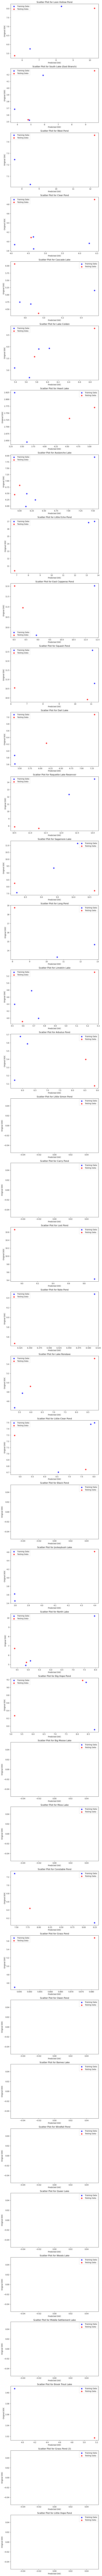

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Preparing the training data
X = merged_data[['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1','LAKE_DEPTH_MEAN']]  # Features
y = merged_data['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 2:
        # Skip this lake group as it has insufficient data for splitting
        continue

    X_lake = lake_group[['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict DOC values for both training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Create DataFrames for the training and testing data with all bands and the predicted values
data_train = X_train.copy()
data_train['original_DOC'] = y_train
data_train['predicted_DOC'] = y_pred_train

data_test = X_test.copy()
data_test['original_DOC'] = y_test
data_test['predicted_DOC'] = y_pred_test

# Set up the subplots based on the number of unique 'LAKE_LABEL' values
num_lake_labels = len(merged_data['LAKE_LABEL'].unique())
fig, axes = plt.subplots(nrows=num_lake_labels, ncols=1, figsize=(8, 5 * num_lake_labels))

# Loop through each 'LAKE_LABEL' and create a scatter plot for predicted vs. original DOC
for i, label in enumerate(merged_data['LAKE_LABEL'].unique()):
    # Filter data for the current 'LAKE_LABEL'
    data_train_label = data_train[merged_data['LAKE_LABEL'] == label]
    data_test_label = data_test[merged_data['LAKE_LABEL'] == label]

    # Get the lake_name corresponding to the lake_label
    lake_name = lake_names[int(label)]

    # Plot the scatter plot for the training data
    axes[i].scatter(data_train_label['predicted_DOC'], data_train_label['original_DOC'], color='blue', label='Training Data')

    # Plot the scatter plot for the testing data
    axes[i].scatter(data_test_label['predicted_DOC'], data_test_label['original_DOC'], color='red', label='Testing Data')

    # Set plot title and labels
    axes[i].set_title(f'Scatter Plot for {lake_name}')
    axes[i].set_xlabel('Predicted DOC')
    axes[i].set_ylabel('Original DOC')
    axes[i].legend()

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [18]:
# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data***************')
data_train

*************Predicted Training data***************


,Aerosols,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge4,NIR,SWIR1,LAKE_DEPTH_MEAN,original_DOC,predicted_DOC
15500,1.0247,1.0430,1.0157,1.0100,1.0071,0.9798,0.9831,0.8997,0.1513,5.8,9.131399,8.400973
15692,0.0043,0.0060,0.0026,0.0031,0.0035,0.0032,0.0036,0.0046,0.0072,5.8,7.907400,8.780633
15347,0.0233,0.0087,0.0074,0.0050,0.0067,0.0102,0.0134,0.0118,0.0205,4.1,9.624900,8.933388
15488,0.3176,0.7896,0.7686,0.7819,0.8322,0.8186,0.8306,0.7532,0.1552,4.1,12.015331,11.372514
15655,1.0893,1.0957,1.0599,1.0579,1.0853,1.0610,1.0397,0.9732,0.1551,5.5,7.474600,7.867937
15443,0.0077,0.0083,0.0059,0.0033,0.0040,0.0083,0.0125,0.0102,0.0067,5.5,7.496900,8.020047
15691,0.0097,0.0092,0.0080,0.0073,0.0097,0.0089,0.0118,0.0112,0.0169,5.5,6.702900,6.547054
15284,1.2071,1.1988,1.1221,1.1152,1.1127,1.0845,1.1098,1.0054,0.1499,3.4,8.126200,8.319907
15433,0.0099,0.0102,0.0114,0.0066,0.0078,0.0115,0.0141,0.0139,0.0077,3.4,5.749400,6.460696
15541,0.0341,0.0372,0.0348,0.0279,0.0294,0.0297,0.0311,0.0269,0.0229,6.1,4.779552,4.679660


In [19]:
print(f'*************Predicted Testing data***************')

data_test


*************Predicted Testing data***************


,Aerosols,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge4,NIR,SWIR1,LAKE_DEPTH_MEAN,original_DOC,predicted_DOC
15654,1.0670,1.0520,1.0170,1.0202,1.0372,0.9962,0.9788,0.9111,0.1116,5.8,9.181600,8.241554
15774,0.0664,0.0621,0.0528,0.0379,0.0447,0.0616,0.0540,0.0534,0.0130,5.8,8.268000,5.163972
15442,0.0057,0.0067,0.0073,0.0056,0.0173,0.0366,0.0326,0.0588,0.0366,4.1,10.955500,8.370192
15509,0.0200,0.0078,0.0072,0.0070,0.0083,0.0092,0.0174,0.0213,0.0249,4.1,12.007031,8.021990
15499,0.8771,1.0551,1.0290,1.0198,1.0496,1.0354,1.0389,0.9512,0.1546,5.5,6.745973,7.663568
15771,0.0830,0.0794,0.0720,0.0510,0.0639,0.1011,0.0984,0.0978,0.0257,5.5,7.293800,4.775136
15304,0.9155,0.9114,0.8678,0.8702,0.8766,0.8547,0.8430,0.7803,0.0270,3.4,8.023800,10.275420
15544,0.0629,0.0618,0.0588,0.0540,0.0606,0.0617,0.0593,0.0634,0.0577,3.4,5.369758,5.552776
15510,0.0216,0.0162,0.0185,0.0170,0.0189,0.0157,0.0143,0.0165,0.0196,6.1,3.902542,4.593755
15795,0.2214,0.2194,0.1990,0.1803,0.2032,0.2685,0.3295,0.3132,0.2172,6.1,5.311700,5.264384


In [20]:
# Calculate the Mean Squared Error (MSE) for the testing data
mse_test = mean_squared_error(y_test, y_pred_test)

#MSE assesses the average squared difference between the observed and predicted values.

# Print the MSE for the testing data
print("Mean Squared Error (Testing):", mse_test)

#Mean Squared Error (Testing): 7.494766018856799


Mean Squared Error (Testing): 7.510650425530897


# All Lakes in one Plot without Lake_label as features

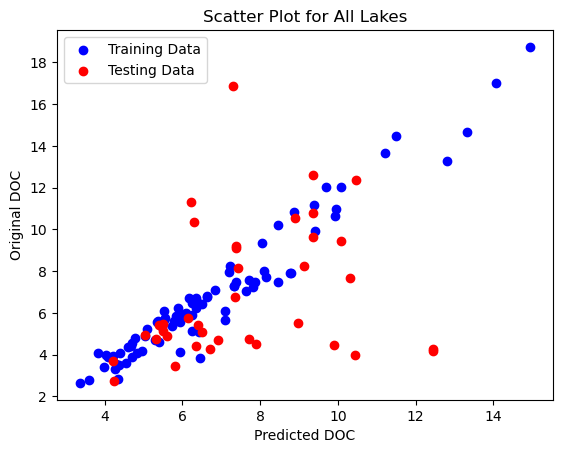

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Preparing the training data
X = merged_data[['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1','LAKE_DEPTH_MEAN']]  # Features
y = merged_data['DOC_MG_L']  # Target variable

# Train-test split for all lakes combined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict DOC values for both training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Create DataFrames for the training and testing data with all bands and the predicted values
data_train = X_train.copy()
data_train['original_DOC'] = y_train
data_train['predicted_DOC'] = y_pred_train

data_test = X_test.copy()
data_test['original_DOC'] = y_test
data_test['predicted_DOC'] = y_pred_test

# Plot the scatter plot for all lakes combined
plt.scatter(data_train['predicted_DOC'], data_train['original_DOC'], color='blue', label='Training Data')
plt.scatter(data_test['predicted_DOC'], data_test['original_DOC'], color='red', label='Testing Data')

# Set plot title and labels
plt.title('Scatter Plot for All Lakes')
plt.xlabel('Predicted DOC')
plt.ylabel('Original DOC')
plt.legend()

# Show the plot
plt.show()


# Lake_LABEL AS FEATURE 

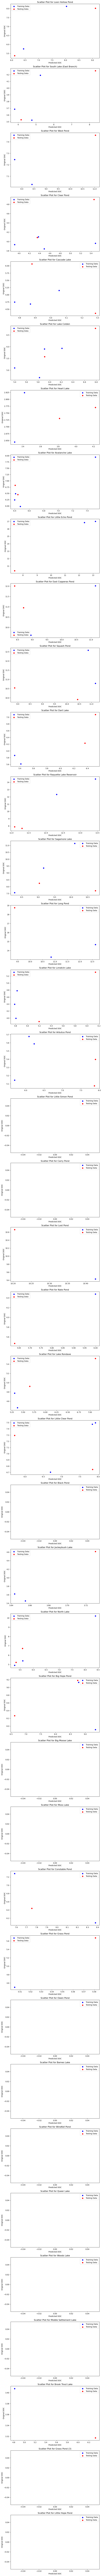

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Preparing the training data
X = merged_data[['LAKE_LABEL', 'Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']]  # Features
y = merged_data['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 2:
        # Skip this lake group as it has insufficient data for splitting
        continue

    X_lake = lake_group[['LAKE_LABEL', 'Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict DOC values for both training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Create DataFrames for the training and testing data with all bands and the predicted values
data_train = X_train.copy()
data_train['original_DOC'] = y_train
data_train['predicted_DOC'] = y_pred_train

data_test = X_test.copy()
data_test['original_DOC'] = y_test
data_test['predicted_DOC'] = y_pred_test

# Set up the subplots based on the number of unique 'LAKE_LABEL' values
num_lake_labels = len(merged_data['LAKE_LABEL'].unique())
fig, axes = plt.subplots(nrows=num_lake_labels, ncols=1, figsize=(8, 5 * num_lake_labels))

# Loop through each 'LAKE_LABEL' and create a scatter plot for predicted vs. original DOC
for i, label in enumerate(merged_data['LAKE_LABEL'].unique()):
    # Filter data for the current 'LAKE_LABEL'
    data_train_label = data_train[data_train['LAKE_LABEL'] == label]
    data_test_label = data_test[data_test['LAKE_LABEL'] == label]

    # Get the lake_name corresponding to the lake_label
    lake_name = lake_names[int(label)]

    # Plot the scatter plot for the training data
    axes[i].scatter(data_train_label['predicted_DOC'], data_train_label['original_DOC'], color='blue', label='Training Data')

    # Plot the scatter plot for the testing data
    axes[i].scatter(data_test_label['predicted_DOC'], data_test_label['original_DOC'], color='red', label='Testing Data')

    # Set plot title and labels
    axes[i].set_title(f'Scatter Plot for {lake_name}')
    axes[i].set_xlabel('Predicted DOC')
    axes[i].set_ylabel('Original DOC')
    axes[i].legend()

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()


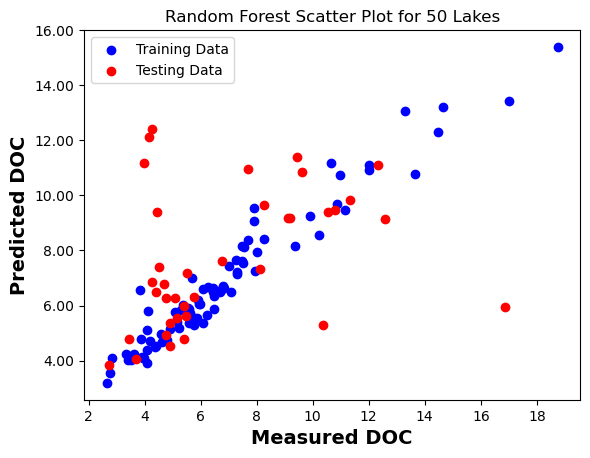

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Preparing the training data
X = merged_data[['LAKE_LABEL', 'Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']]  # Features
y = merged_data['DOC_MG_L']  # Target variable

# Train-test split for all lakes combined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict DOC values for both training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Create DataFrames for the training and testing data with all bands and the predicted values
data_train = X_train.copy()
data_train['original_DOC'] = y_train
data_train['predicted_DOC'] = y_pred_train

data_test = X_test.copy()
data_test['original_DOC'] = y_test
data_test['predicted_DOC'] = y_pred_test

# Plot the scatter plot for all lakes combined
plt.scatter( data_train['original_DOC'], data_train['predicted_DOC'],color='blue', label='Training Data')
plt.scatter( data_test['original_DOC'],data_test['predicted_DOC'], color='red', label='Testing Data')

# Set plot title and labels
plt.title('Random Forest Scatter Plot for 50 Lakes')
plt.xlabel('Measured DOC', fontsize=14, fontweight="bold")
plt.ylabel('Predicted DOC',  fontsize=14, fontweight="bold")
# Set y-axis labels to display two decimal places
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.legend()

# Show the plot
plt.show()


In [24]:
# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data***************')
data_train

*************Predicted Training data***************


,LAKE_LABEL,Aerosols,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge4,NIR,SWIR1,LAKE_DEPTH_MEAN,original_DOC,predicted_DOC
15515,28.0,0.1399,0.1380,0.1481,0.1367,0.1846,0.2453,0.2582,0.2770,0.2177,2.8,5.587261,5.863238
15774,1.0,0.0664,0.0621,0.0528,0.0379,0.0447,0.0616,0.0540,0.0534,0.0130,5.8,8.268000,8.409580
15338,35.0,0.0301,0.0212,0.0180,0.0122,0.0114,0.0090,0.0114,0.0098,0.0146,4.2,4.361700,4.509851
15441,33.0,0.0045,0.0130,0.0180,0.0098,0.0086,0.0030,0.0097,0.0081,0.0065,5.1,2.770000,3.536266
15401,47.0,0.0153,0.0096,0.0102,0.0084,0.0111,0.0091,0.0201,0.0209,0.0172,2.3,6.477600,5.866839
15536,24.0,0.0415,0.0321,0.0383,0.0231,0.0624,0.1496,0.1652,0.2020,0.1072,1.6,14.460157,12.314886
15427,22.0,0.0064,0.0147,0.0261,0.0230,0.0423,0.1248,0.1609,0.1957,0.0787,3.3,7.944500,7.257858
15771,6.0,0.0830,0.0794,0.0720,0.0510,0.0639,0.1011,0.0984,0.0978,0.0257,5.5,7.293800,7.134641
15563,16.0,0.0212,0.0210,0.0324,0.0277,0.0577,0.1036,0.1342,0.1381,0.0897,0.7,10.660516,11.174548
15319,35.0,0.4133,0.3416,0.3379,0.3174,0.3111,0.2495,0.1917,0.1577,0.0222,4.2,5.148900,5.410166


In [25]:
print(f'*************Predicted Testing data***************')

data_test


*************Predicted Testing data***************


,LAKE_LABEL,Aerosols,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge4,NIR,SWIR1,LAKE_DEPTH_MEAN,original_DOC,predicted_DOC
15499,6.0,0.8771,1.0551,1.0290,1.0198,1.0496,1.0354,1.0389,0.9512,0.1546,5.5,6.745973,7.629779
15508,21.0,0.2744,0.2624,0.2473,0.2347,0.2250,0.2308,0.2431,0.2294,0.0288,2.3,4.682251,6.799847
15318,45.0,0.4859,0.6954,0.6822,0.6720,0.6900,0.6555,0.5826,0.5689,0.0317,9.2,4.902200,4.516484
15518,49.0,0.1945,0.1846,0.1705,0.1641,0.1934,0.2187,0.2065,0.2428,0.2280,8.3,3.686040,4.057575
15413,39.0,0.3224,0.1549,0.2027,0.2429,0.2782,0.3470,0.2571,0.4068,0.2586,3.0,4.772000,6.263187
15529,48.0,0.0233,0.0192,0.0196,0.0168,0.0233,0.0232,0.0271,0.0288,0.0217,1.5,4.499849,7.415373
15540,47.0,0.0182,0.0132,0.0147,0.0107,0.0153,0.0159,0.0193,0.0255,0.0209,2.3,5.467659,5.615066
15346,37.0,0.0709,0.0878,0.0879,0.0854,0.0974,0.1133,0.1377,0.1183,0.1143,2.9,10.358000,5.290104
15474,49.0,0.0004,0.0018,0.0014,0.0012,0.0005,0.0001,0.0013,0.0026,0.0021,8.3,4.257446,12.428567
15687,39.0,0.0119,0.0084,0.0070,0.0076,0.0073,0.0090,0.0090,0.0071,0.0083,3.0,5.523300,7.169963


In [26]:
# Calculate the Mean Squared Error (MSE) for the testing data
mse_test = mean_squared_error(y_test, y_pred_test)

#MSE assesses the average squared difference between the observed and predicted values.

# Print the MSE for the testing data
print("Mean Squared Error (Testing):", mse_test)

#Mean Squared Error (Testing): 5.0658002329403535


Mean Squared Error (Testing): 11.478267603636032
